## Planet Mass Using Disk Planet Neural Network (DPNNet) 

In [1]:
'''
    Introduction to DPNNet (Disk Planet Neural Network)
    
    AIM: To apply DPNNet to evaluate planet mass from observed Protoplanetary Disk Gaps in dust emission
    
    Application: 1. Apply the trained network to test-dataset to compare model performance
                 2. Demonstrate the application of the model to predict planet masses in HL Tau and AS 209
                 3. Compare with Kanagawa and Lodato models with error estimate
                 
    Background:  The DPNNet is trained using the simulation data: We import the trained Model
                 with it's optimized weights.
    
    This script modified version of the one used in Auddy & Lin 2020 paper
    
    
'''

# Author :Sayantan
# Created : 20 April 2020
# updated : 14 August 2020

import pathlib
import glob
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import matplotlib as mpl


mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'

import numpy as np
print(tf.__version__)

2.0.0


In [2]:
## Import the data 
dataset_raw = pd.read_csv('data_folder/dataset_raw.csv',index_col=0) ## raw data 

dataset = pd.read_csv('data_folder/dataset_filered.csv',index_col=0) ## filtered data 
# train_dataset = pd.read_csv('train_dataset.csv',index_col=0) ## trained dataset

test_dataset = pd.read_csv('data_folder/test_dataset.csv',index_col=0)  ## test dataset
test_labels = test_dataset.pop("Planet_Mass")               ## test labels

## Import the training set stats to normalise test_data
train_stats = pd.read_csv('data_folder/train_stats.csv',index_col=0)
## same normalization at the training dataset
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_test_data = norm(test_dataset)
# test_dataset
# train_dataset
test_labels

9       35.666667
11      16.266667
19     113.333333
23      77.666667
28      62.666667
          ...    
760     96.666667
766     70.000000
768    102.333333
773    106.000000
787     73.666667
Name: Planet_Mass, Length: 157, dtype: float64

In [3]:
# Statistics of the raw data
dataset_raw_stats = dataset_raw.describe()
dataset_raw_stats = dataset_raw_stats.transpose()
dataset_raw_stats
# Statistics of the entire data after the intitial filtering
dataset_stats = dataset.describe()
dataset_stats = dataset_stats.transpose()
dataset_stats
# sns.pairplot(dataset_raw[["Planet_Mass","Epsilon","Alpha", "Stokes","Aspect_Ratio" ,"Dust_gap_1",'SigmaSlope']], diag_kind="kde")

,count,mean,std,min,25%,50%,75%,max
Planet_Mass,783.0,7.400047e+01,3.010557e+01,8.500000e+00,5.133333e+01,7.766667e+01,9.983333e+01,120.000000
Epsilon,783.0,5.545160e-02,2.588731e-02,1.000000e-02,3.305000e-02,5.540000e-02,7.805000e-02,0.100000
Alpha,783.0,4.847227e-03,2.890969e-03,1.040000e-04,2.315000e-03,4.720000e-03,7.365000e-03,0.009990
Stokes,783.0,4.965685e-02,2.801292e-02,1.120000e-03,2.585000e-02,4.870000e-02,7.405000e-02,0.099900
Aspect_Ratio,783.0,5.359451e-02,1.857629e-02,2.500000e-02,3.780000e-02,5.140000e-02,6.760000e-02,0.099400
SigmaSlope,783.0,9.971967e-01,2.913520e-01,5.000000e-01,7.425000e-01,9.950000e-01,1.250000e+00,1.500000
Dust_gap_1,783.0,6.329029e-01,2.701734e-01,5.300000e-02,6.340000e-01,7.260000e-01,7.980000e-01,1.050000
Gas_gap_1,783.0,1.431060e-01,1.573849e-01,0.000000e+00,0.000000e+00,0.000000e+00,2.910000e-01,0.669000
Dust_depth_1,783.0,2.161702e-07,5.489862e-07,3.210000e-75,9.295000e-18,1.880000e-10,1.095000e-07,0.000005
Gas_depth_1,783.0,1.123983e-05,1.504267e-05,0.000000e+00,0.000000e+00,0.000000e+00,2.210000e-05,0.000052


[151.56431002]


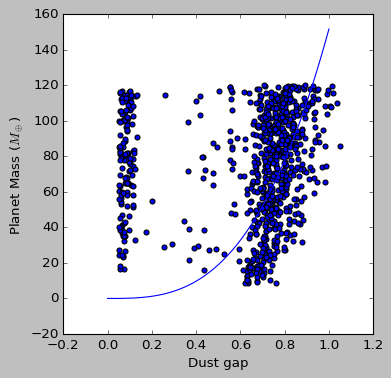

In [23]:
## Fitting the Lodato realtion to obtain the new normalization
def Lodato_fit(x,A):
    return A*x**3
from scipy import optimize
plt.figure(figsize = (5,5))
popt, pcov = optimize.curve_fit(Lodato_fit, dataset["Dust_gap_1"], dataset["Planet_Mass"])
print(popt)
plt.scatter(dataset["Dust_gap_1"],dataset["Planet_Mass"])
plt.xlabel("Dust gap")
plt.ylabel("Planet Mass ($M_\oplus$) ")
x = np.linspace(0,1,100)
y = popt*x**3
plt.plot(x,y)
plt.show()

[15.14027507]


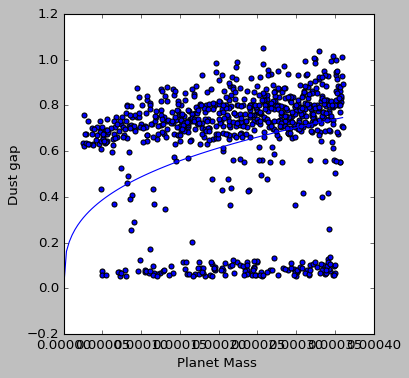

In [24]:
def Lodato_fit(x,A):
    return A*(x/3)**(1/3)
from scipy import optimize
popt1, pcov1 = optimize.curve_fit(Lodato_fit,dataset["Planet_Mass"]*(3*10**-6),dataset["Dust_gap_1"])
print(popt1)
plt.figure(figsize = (5,5))
plt.scatter(dataset["Planet_Mass"]*(3*10**-6),dataset["Dust_gap_1"])
plt.ylabel("Dust gap")
plt.xlabel("Planet Mass ")
plt.xlim(0.0,0.0004)
x = np.linspace(0,max(dataset["Planet_Mass"]*(3*10**-6)),100)
y = popt1*(x/3)**(1/3)
plt.plot(x,y)
plt.show()

In [6]:
# Make a folder for saving the plots
output_figure = "figure_Paper"
!mkdir -p figure_Paper

In [7]:
## import the DPNNet 
model = tf.keras.models.load_model('saved_model/my_model')
# Check its architecture
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 256)               2048      
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 35,073
Trainable params: 35,073
Non-trainable params: 0
_________________________________________________________________


# Model performance 

In [8]:
# Model performance 
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)
print("Testing set Mean Square Error: {:5.2f} ".format(mse))
print("Testing set Root Mean Square Error: {:5.2f} M_Earth".format(np.sqrt(mse)))
print("Testing set Mean Abs Error: {:5.2f} M_Earth".format(mae))
print("Testing set Loss : {:5.2f} M_Earth".format(loss))

## We define the model error as the average of the RMSE obtained using K-Fold cross validation
f = open("MSE_K-Fold.txt", "r")
MSE_KFolds = []
for line in f:
    MSE_KFolds.append(float(line))
f.close()
# print(MSE_KFolds)
print(np.mean(MSE_KFolds))
SD = np.sqrt(np.mean(MSE_KFolds))
print("SD = ",SD)

Testing set Mean Square Error: 185.38 
Testing set Root Mean Square Error: 13.62 M_Earth
Testing set Mean Abs Error:  9.84 M_Earth
Testing set Loss : 185.44 M_Earth
285.7016906738281
SD =  16.902712524143222


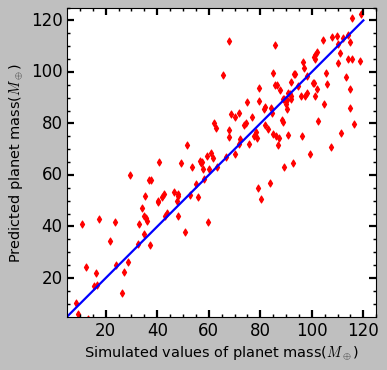

In [9]:
plt.style.use('classic')
plt.figure(figsize = (5,5))
test_predictions = model.predict(normed_test_data).flatten()
plt.scatter(test_labels, test_predictions,s=20,marker='d',color='r')

plt.xlabel(r'Simulated values of planet mass($M_\oplus$)', fontsize=13)
plt.ylabel(r'Predicted planet mass($M_\oplus$)',fontsize=13)
plt.axis('equal')
plt.axis('square')
plt.xlim(5,125)
plt.ylim(5,125)
# plt.xlim([0.6,plt.xlim()[1]])
# plt.ylim([0.6,plt.xlim()[1]])
_ = plt.plot([0, 120], [0, 120],linewidth=2)

plt.minorticks_on() 
plt.tick_params(labelsize=15)
plt.tick_params(axis='both', which='major',length=6, width=2)
plt.tick_params(axis='both', which='minor',length=3, width=1.3)
plt.tight_layout()
plt.savefig(output_figure +'/predicted_correlation.pdf',format='pdf',dpi=300)
# plt.savefig('figures/predicted_correlation.eps',format='eps',dpi=300)

## Using DPNNet to predict the planet mass from observed gap widths in HL-Tau

In [10]:
##  Lets predict the Mass of Hl Tau disk

## need to guess from the observation
Epsilon = 0.01
SigmaSlope = 1 ## this is the mean value from the parameter space
Stokes = 0.005
Alpha = 0.001

## Will use the values from the Kanagawa paper
Aspect_Ratio= [0.05,0.07,0.1]
Dust_gap = [0.81,0.23,0.29]

Dust_gap_2 = 0.000 ## using a default value of zero

for index in range(len(Aspect_Ratio)):
    df_HL = pd.DataFrame(data=[[Epsilon,Alpha,Stokes,Aspect_Ratio[index],SigmaSlope,Dust_gap[index],Dust_gap_2]],columns=["Epsilon", "Alpha", "Stokes","Aspect_Ratio","SigmaSlope","Dust_gap_1","Dust_gap_2"])
    print("The Predicted planet mass in ring#",index,"is",model.predict(norm(df_HL)))
    K_mass = (2.1*10**-3*(Dust_gap[index])**2 * 
                     (Aspect_Ratio[index]/0.05)**(3/2) *
                     (Alpha/10**-3)**0.5)/(3*10**-6)
    print("The Kanagawa Predicted planet mass in ring#", K_mass)

The Predicted planet mass in ring# 0 is [[84.54099]]
The Kanagawa Predicted planet mass in ring# 459.2700000000001
The Predicted planet mass in ring# 1 is [[62.660957]]
The Kanagawa Predicted planet mass in ring# 61.34028162309008
The Predicted planet mass in ring# 2 is [[104.2411]]
The Kanagawa Predicted planet mass in ring# 166.50950483380822


## Using DPNNet to predict the planet mass from observed gap widths in AS 209

In [11]:
##Predict the planet mass in AS 209 disk
## Note that the central star in 0.83 M_{\sun}
# AS209_1 Paramters used from Zhang et al 2018


M_star = 0.83 ## from Zhang et al 2018
Dust_gap_2 = 0.00 ## using a default value of zero

Dust_gap = 0.42
Epsilon = 0.012 # 1.23/100
SigmaSlope = 1.0
Stokes = 30*5.23*10**-4
Alpha = 10**-4
Aspect_Ratio = 0.04
df_AS209_1 = pd.DataFrame(data=[[Epsilon,Alpha,Stokes,Aspect_Ratio,SigmaSlope,Dust_gap,Dust_gap_2]]
                     ,columns=["Epsilon", "Alpha", "Stokes","Aspect_Ratio","SigmaSlope","Dust_gap_1","Dust_gap_2"])

print("The Predicted planet mass in ring AS209_1#",model.predict(norm(df_AS209_1))*M_star)

# AS209_2
Dust_gap = 0.31
Epsilon = 0.02   #####0.17/10
SigmaSlope = 1.0
Stokes = 30*5.23*10**-4
Alpha = 10**-4
Aspect_Ratio = 0.08
df_AS209_2 = pd.DataFrame(data=[[Epsilon,Alpha,Stokes,Aspect_Ratio,SigmaSlope,Dust_gap,Dust_gap_2]]
                     ,columns=["Epsilon", "Alpha", "Stokes","Aspect_Ratio","SigmaSlope","Dust_gap_1","Dust_gap_2"])

print("The Predicted planet mass in ring AS209_2#",model.predict(norm(df_AS209_2))*M_star)

The Predicted planet mass in ring AS209_1# [[20.191906]]
The Predicted planet mass in ring AS209_2# [[50.38312]]


## A test case for demonstration in the paper 

In [12]:
## One test case for the demonstration in the paper ##
test_index = 96
print(test_dataset.iloc[[test_index]])
print("Actual Planet Mass is ", test_labels.iloc[[test_index]])
# # normed_test_data.iloc[[4]]
print("Predicted Planet Mass is " , model.predict(normed_test_data.iloc[[test_index]]))

     Epsilon    Alpha  Stokes  Aspect_Ratio  SigmaSlope  Dust_gap_1  \
463   0.0904  0.00725  0.0767        0.0597        1.19       0.632   

     Dust_gap_2  
463         0.0  
Actual Planet Mass is  463    48.0
Name: Planet_Mass, dtype: float64
Predicted Planet Mass is  [[44.11703]]


## Comparing DPNNet with Kanagawa and Lodato model

In [13]:
## Modify the test-dataset removing the data with zero gas gaps. 
## This will give a cleaner dataset for comparison
test_dataset_temp = test_dataset
test_dataset_temp

## Updated test feature
test_dataset_temp['Gas_gap_1'] = dataset.loc[test_dataset.index,'Gas_gap_1']
test_dataset_mod = test_dataset_temp[test_dataset_temp['Gas_gap_1']>0.0]
# test_dataset_mod
# ## Updated test labels
test_labels_mod = test_labels.loc[test_dataset_mod.index]


In [14]:
### calculating the mass perdicted using the Kanagawa formula from gas gap and dust gasp ###
Kanagawa_mass_gas = (2.1*10**-3 * (test_dataset_mod.Gas_gap_1)**2 * 
                     (test_dataset_mod.Aspect_Ratio/0.05)**(3/2) *
                     (test_dataset_mod.Alpha/10**-3)**0.5)/(3*10**-6)

Kanagawa_mass_dust = (2.1*10**-3 * (test_dataset_mod.Dust_gap_1)**2 * 
                     (test_dataset_mod.Aspect_Ratio/0.05)**(3/2) *
                     (test_dataset_mod.Alpha/10**-3)**0.5)/(3*10**-6)


### calculating the mass perdicted using the Lodato formula ###
test_dataset_lodato = test_dataset_mod

# Lodato_mass = (test_dataset_lodato.Dust_gap_1/5.5)**3 * 3/(3*10**-6) 
Lodato_mass =popt*(test_dataset_lodato.Dust_gap_1)**3 
# Lodato_mass = (test_dataset_lodato.Dust_gap_1/popt1)**3 * 3/(3*10**-6) 
test_labels_Lodato = test_labels.loc[test_dataset_lodato.index]


## Calculating the K_prime from the Kanagawa paper
K_prime_g = (test_dataset_mod.Gas_gap_1)**2 * (test_dataset_mod.Aspect_Ratio/0.05)**(3/2) * (test_dataset_mod.Alpha/10**-3)**0.5
K_prime_d = (test_dataset_mod.Dust_gap_1)**2*(test_dataset_mod.Aspect_Ratio/0.05)**(3/2) * (test_dataset_mod.Alpha/10**-3)**0.5

## Using ADNN for predicting the masses of these selected models
test_dataset_com = test_dataset_mod.drop(columns=['Gas_gap_1'])
normed_test_dataset_mod = norm(test_dataset_com)
normed_test_dataset_mod
ADNN_predicted = model.predict(normed_test_dataset_mod).flatten()



In [15]:
## Error estimates
Error_ADNN = (ADNN_predicted - test_labels_mod)
Square_error_ADNN = (ADNN_predicted - test_labels_mod)**2 ## square error ML

Error_K_mass_gas = (Kanagawa_mass_gas - test_labels_mod)
Square_error_kanagawa_gas = (Kanagawa_mass_gas - test_labels_mod)**2 ## square error kanagawa

Error_Lodata_mass = (Lodato_mass - test_labels_mod)
Square_error_Lodato_mass = (Lodato_mass - test_labels_mod)**2 ## square error Lodato

print("ADNN SD Error", np.std(Error_ADNN))
print("ADNN ME", np.mean(Error_ADNN))
print("ADNN RMSE",np.sqrt(np.mean(Square_error_ADNN))) ## the root mean square error in the ADNN model

print("K_mass SD Error",np.std(Error_K_mass_gas))
print("K_mass ME",np.mean(Error_K_mass_gas))
print("K_mass RMSE",np.sqrt(np.mean(Square_error_kanagawa_gas))) ## the root mean square error in the Kanagawa model


print("L_mass SD Error",np.std(Error_Lodata_mass))
print("L_mass ME",np.mean(Error_Lodata_mass))
print("L_mass RMSE",np.sqrt(np.mean(Square_error_Lodato_mass))) ## the root mean square error in the Lodato Mass


ADNN SD Error 13.265781655321195
ADNN ME -1.1615580018361387
ADNN RMSE 13.316537835274074
K_mass SD Error 47.42148043921326
K_mass ME -0.81551495392631
K_mass RMSE 47.42849219284505
L_mass SD Error 32.2680422077807
L_mass ME -1.2921437629977859
L_mass RMSE 32.293903192822185


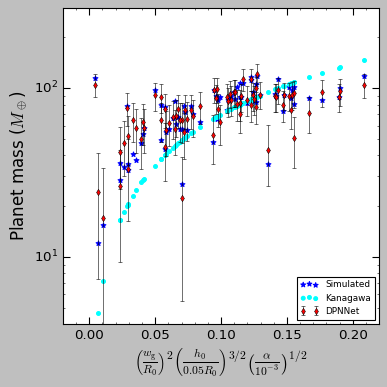

In [16]:
f, ax1 = plt.subplots(1, 1, sharey=False,sharex=False,figsize=(5,5))
# fcecolor='red'

ax1.scatter(K_prime_g,test_labels_mod,s=20,marker='*',color='blue',label= 'Simulated')
ax1.errorbar(K_prime_g,ADNN_predicted, yerr=SD, lw=0,elinewidth=0.5,ecolor='k', fmt='d',markersize=4,color='red',capsize=2,label= 'DPNNet')
ax1.scatter(K_prime_g,Kanagawa_mass_gas,s=12,marker='o',color='cyan',label= 'Kanagawa')
# ax1.scatter(K_prime_g,Kanagawa_mass_dust,s=15,marker='^',color='k', label= 'K_mass from dust gaps')


ax1.set_yscale('log')
ax1.set_xlim(-.02,0.22)
ax1.set_ylim(4,300)
ax1.minorticks_on() 
ax1.tick_params(labelsize=12)
ax1.tick_params(axis='both', which='major',length=6, width=1)
ax1.tick_params(axis='both', which='mainor',length=3, width=1.3)
ax1.legend(loc=4,fontsize=8)
ax1.set_xlabel(r'$\left(\frac{w_{\rm g}}{R_{\rm 0}}\right)^2\left(\frac{h_{\rm 0}}{0.05 R_{\rm 0}}\right)^{3/2}\left(\frac{\alpha}{10^{-3}}\right)^{1/2}$', 
           fontsize=15)
ax1.set_ylabel(r'Planet mass ($M_\oplus$)',fontsize=15)


# ax2.hist(Error_ADNN, bins = 30,edgecolor='red', linewidth=2.0, histtype='step', stacked=True,fill=False, label= "ADNN ")
# ax2.hist(Error_K_mass_gas , bins = 30,edgecolor='cyan', linewidth=2.0, histtype='step', stacked=True, fill=False, label = "Kanagawa")
# ax2.set_xlabel(r"Prediction Error($M_\oplus$)", Fontsize=15)
# ax2.set_ylabel("Count",Fontsize=15)
# ax2.minorticks_on() 
# ax2.tick_params(labelsize=12)
# ax2.tick_params(axis='both', which='major',length=5, width=1)
# ax2.tick_params(axis='both', which='mainor',length=3, width=1.3)
# ax2.legend(loc=1,fontsize=8)
# ax2.set_xlim(-80,80)


# plt.legend(loc=4,fontsize =10)
# plt.xlim(-.02,0.22)

plt.tight_layout()

plt.savefig(output_figure +"/comparison_gas_gap.pdf",format='pdf',dpi=300)


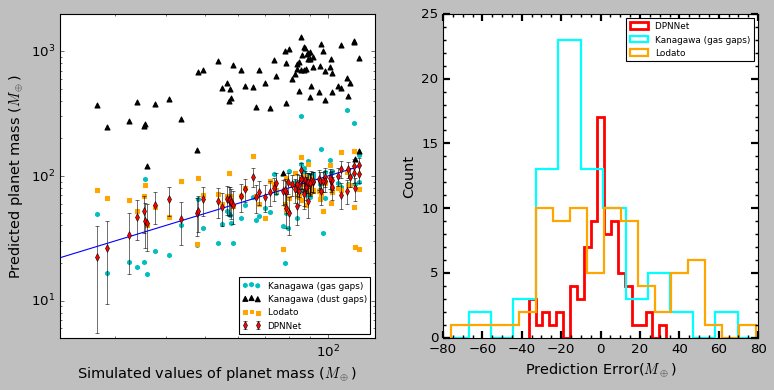

In [17]:
f, [ax1,ax2] = plt.subplots(1, 2, sharey=False,sharex=False,figsize=(10,5))
ax1.errorbar(test_labels_mod,ADNN_predicted, yerr=SD, lw=0,elinewidth=0.5,ecolor='k', fmt='d',markersize=5,color='red',capsize=2,label= 'DPNNet')
ax1.scatter(test_labels_mod,Kanagawa_mass_gas,s=15,marker='h',color='c',label= 'Kanagawa (gas gaps)')
ax1.scatter(test_labels_mod,Kanagawa_mass_dust,marker='^',color='k',label= 'Kanagawa (dust gaps)')
ax1.scatter(test_labels_Lodato,Lodato_mass,s=12,marker='s',color='orange',label= 'Lodato ')

ax1.set_xlabel(r'Simulated values of planet mass ($M_\oplus$)', fontsize=13)
ax1.set_ylabel(r'Predicted planet mass ($M_\oplus$)',fontsize=13)
ax1.legend(loc=4,fontsize=8)
_ = ax1.plot([0, 120], [0, 120])

ax2.hist(Error_ADNN, bins = 20,edgecolor='red', linewidth=2.5, histtype='step', stacked=False,fill=False,color='red', label= "DPNNet ")
ax2.hist(Error_K_mass_gas , bins = 30,edgecolor='cyan', linewidth=2, histtype='step', stacked=False, fill=False, label = "Kanagawa (gas gaps)")
ax2.hist(Error_Lodata_mass , bins = 20,edgecolor='orange', linewidth=2, histtype='step', stacked=False, fill=False, label = "Lodato")
ax2.set_xlabel(r"Prediction Error($M_\oplus$)", Fontsize=13)
ax2.set_ylabel("Count",Fontsize=13)
ax2.minorticks_on() 
ax2.tick_params(labelsize=12)
ax2.tick_params(axis='both', which='major',length=5, width=1)
ax2.tick_params(axis='both', which='mainor',length=3, width=1.3)
ax2.legend(loc=1,fontsize=8)
ax2.set_xlim(-80,80)

plt.minorticks_on() 
plt.tick_params(labelsize=12)
plt.tick_params(axis='both', which='major',length=6, width=2)
plt.tick_params(axis='both', which='minor',length=3, width=1.3)
# plt.axis('equal')
# plt.axis('square')
plt.tight_layout()
# plt.xlim(5,125)
# plt.ylim(5,125)
# _ = plt.plot([0, 120], [0, 120],linewidth=2)
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_xlim(22,130)
# ax1.set_ylim(1,100)
ax1.set_ylim(5,2000)
plt.savefig(output_figure +"/model_correlation.pdf",format='pdf',dpi=300)